# 0.0 Table of Contents

1. [Introduction](#1.0-Introduction)

2. [Feature Analysis](#2.0-Feature-Analysis)

# 1.0 Introduction
 

### 1.1 Project -  Binary classification of bitcoin addresses

-  **GOAL:** to predict whether an address has been the recipient of ransomware coins. 

-  **DATA:**  Data is time series (24hr chunks) derived from the topological and geometrical properties of the bitcoin network.

### 1.2 Basics

- Ransomware is a rogue compute code that encrypts the victim's filesystem unless money is paid to the attacker for decryption. 

- Bitcoin is often used for these payments because it provides a semi-anonymous transaction method.  

- The dataset was taken from the UCI Machine Learning Repository. It contains labelled data of addresses according to whether they have been involved in Ransomware. The data is from 2009 January to 2018 December. 
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

### 1.2.0 Breakdown

---
**"starter transactions"**: transactions which are spent outputs from the  previous time window <n>

Features:

- The **address** is a public BC address which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC).
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses.
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from a starter
transaction and ending at address $a$. Count captures
information about the number of transactions, whereas weight
 gives information about the amount of coins.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain). 
    
       
<n>
Engineered/derived features:
    
- bc_income = boxcox of income
    
- bc_length = boxcox of length
    
- yeo_weight = yeo of weight
   
- logbc_n_address = boxcox log of address

- bc_neighbors = box of neighbors
   
- sig_looped = sigmoid of looped
    
- log_count = log of count
   
- day_of_week = {'Monday':0,...,'Sunday': 6}

### 1.3 Packages and helper functions

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import datetime
import warnings

from scipy import stats
from scipy.stats import boxcox, yeojohnson
from scipy.stats import shapiro

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, plot_roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = False
DS_FRAC = .12
NF = 7

### 1.4 Importing data

In [4]:
dft = pd.read_csv('dft.csv')

In [5]:
df = pd.read_csv('data/BitcoinHeistData.csv')
df = df.sample(frac=DS_FRAC, axis=0,random_state=RAND_STATE) # take a sample portion of the data


#dft = df.copy()
ROWS = df.shape[0]
COLS = df.shape[1]
ROWS,COLS


(350004, 10)

In [6]:
df.label.value_counts()

white                          345060
paduaCryptoWall                  1476
montrealCryptoLocker             1144
princetonCerber                  1083
princetonLocky                    785
montrealCryptXXX                  293
montrealDMALockerv3                51
montrealNoobCrypt                  45
montrealDMALocker                  26
montrealSamSam                     11
montrealGlobe                       7
montrealCryptoTorLocker2015         5
montrealGlobeImposter               5
montrealWannaCry                    2
montrealVenusLocker                 2
montrealCryptConsole                2
montrealSam                         1
montrealFlyper                      1
montrealAPT                         1
montrealXLocker                     1
montrealEDA2                        1
montrealJigSaw                      1
montrealRazy                        1
Name: label, dtype: int64

In [7]:
# removing the prefix on some of the labels
study_origins = ["princeton","padua","montreal"] #
for r in study_origins:
    dft['label']=dft['label'].str.replace(r,"")
    df['label']=df['label'].str.replace(r,"")
del study_origins
df.label.value_counts()

white                  345060
CryptoWall               1476
CryptoLocker             1144
Cerber                   1083
Locky                     785
CryptXXX                  293
DMALockerv3                51
NoobCrypt                  45
DMALocker                  26
SamSam                     11
Globe                       7
CryptoTorLocker2015         5
GlobeImposter               5
WannaCry                    2
VenusLocker                 2
CryptConsole                2
Sam                         1
Flyper                      1
APT                         1
XLocker                     1
EDA2                        1
JigSaw                      1
Razy                        1
Name: label, dtype: int64

In [8]:
years = df['year'].unique()
print('The data extends from {} to {}.'.format(years.min(),years.max()))
print('File contains {:d} rows and {} columns'.format(df.shape[0], df.shape[1]))


The data extends from 2011 to 2018.
File contains 350004 rows and 10 columns


In [9]:
features=list(df.columns)[:-1]
print('Feature columns: \n{}'.format(features))

Feature columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


In [10]:
dft

,n_day,address,year,day,length,weight,count,looped,neighbors,income,label
2667698,2637,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,5.772641e+08,white
2013400,1982,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,1.000000e+08,white
2704440,2673,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,2.999500e+08,white
1650833,1620,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,2.990000e+08,white
1586811,1556,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,4.000000e+07,white
...,...,...,...,...,...,...,...,...,...,...,...
2796843,2766,3GATJRb9VFCDRe8wQodrNvUouTWGwjLmhM,2018,211,10,0.125000,1,0,2,2.600785e+10,white
1036846,1006,18JuSPFSb4f1iWgeMenS6kFeRw2FYDX1kz,2013,276,4,0.166667,1,0,2,3.012661e+08,white
1932590,1901,1KSjpKdmpFtbLQqbhCoQ8g127AzGq8CjaY,2016,76,144,0.002160,3928,3809,2,1.213316e+08,white
730452,699,1A3AQAvJLVqne7ud7JT6nb3n1gkhpz7DuT,2012,334,0,1.000000,1,0,1,4.997700e+08,white


In [11]:
graph_fs = ['length', 'weight', 'count', 'neighbors',
            'income']  # features relating to the topological properties of the BC network


In [12]:
print('Datatypes: \n\n{}'.format(df.dtypes))

Datatypes: 

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object


In [13]:
#top_ransomwares_dict = dict(df.label.value_counts().head(10)[1:])
# top10_ransoms_labels = df.label.value_counts()[1:11]
print('The top ransomware types are \n\n', df.label.value_counts()[1:11])

The top ransomware types are 

 CryptoWall      1476
CryptoLocker    1144
Cerber          1083
Locky            785
CryptXXX         293
DMALockerv3       51
NoobCrypt         45
DMALocker         26
SamSam            11
Globe              7
Name: label, dtype: int64


In [14]:
 df.groupby('label').mean()

,year,day,length,weight,count,looped,neighbors,income
label,,,,,,,,
APT,2016.000000,259.000000,2.000000,1.500000,2.000000,0.000000,2.000000,7.449526e+07
Cerber,2016.328717,184.969529,42.035088,0.296815,752.451524,36.006464,2.021237,1.045140e+08
CryptConsole,2017.000000,51.000000,72.000000,0.708110,1313.500000,0.000000,2.000000,4.396725e+07
CryptXXX,2016.000000,167.706485,48.648464,0.352714,810.068259,45.737201,1.982935,1.326294e+08
CryptoLocker,2013.038462,241.284091,30.968531,0.840725,273.887238,84.938811,2.868881,1.947917e+09
CryptoTorLocker2015,2015.000000,163.600000,32.400000,0.986878,264.800000,247.600000,8.400000,6.175042e+08
CryptoWall,2014.261518,140.262873,48.891599,0.767319,435.352304,128.550136,2.007453,6.888960e+08
DMALocker,2015.653846,117.576923,19.384615,0.917706,441.961538,122.000000,1.692308,6.963475e+08
DMALockerv3,2016.470588,188.745098,44.666667,0.530395,999.470588,127.117647,1.176471,8.428249e+08


In [15]:
print('The data is over 95% unbalanced towards clean transactions!\n\nwhite label cnt: {}\nrannsomware label cnt: {}'\
      .format(df['label'].value_counts()[0], 
        sum(df['label'].value_counts()[1:])
             ))


The data is over 95% unbalanced towards clean transactions!

white label cnt: 345060
rannsomware label cnt: 4944


## 1.7 Time Series Analysis

In [16]:
def gen_n_day_col(df):
    """
    converts year+day into an integer counting days starting from the first day (time=1) and creates a new column
    :param df: data frame we add a time step col to
    :return: data frame with a new column named t_step_name "at the front" counting days from the start of the data
    """

    t_step_name = 'n_day'
    start = 2011
    year  = 365

    cols = [t_step_name]+list(df.columns) # we want to put the time id at the front of the data frame
    df[t_step_name] = ''

    for idx, _ in tqdm(df.iterrows(),total=df.shape[0]):
        off_set = (df['year'][idx]-start)*year
        df[t_step_name][idx] = df['day'][idx] + off_set

    return df[cols]

In [17]:
#dft    = gen_n_day_col(dft)
#top_df = gen_n_day_col(top_df)

In [18]:
#dft.to_csv("dft.csv",index_label=False)

In [19]:
#dft = pd.read_csv('dft.csv')

In [20]:
dft

,n_day,address,year,day,length,weight,count,looped,neighbors,income,label
2667698,2637,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,5.772641e+08,white
2013400,1982,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,1.000000e+08,white
2704440,2673,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,2.999500e+08,white
1650833,1620,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,2.990000e+08,white
1586811,1556,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,4.000000e+07,white
...,...,...,...,...,...,...,...,...,...,...,...
2796843,2766,3GATJRb9VFCDRe8wQodrNvUouTWGwjLmhM,2018,211,10,0.125000,1,0,2,2.600785e+10,white
1036846,1006,18JuSPFSb4f1iWgeMenS6kFeRw2FYDX1kz,2013,276,4,0.166667,1,0,2,3.012661e+08,white
1932590,1901,1KSjpKdmpFtbLQqbhCoQ8g127AzGq8CjaY,2016,76,144,0.002160,3928,3809,2,1.213316e+08,white
730452,699,1A3AQAvJLVqne7ud7JT6nb3n1gkhpz7DuT,2012,334,0,1.000000,1,0,1,4.997700e+08,white


In [21]:
def test_train_time(X, y, t0):
    """ takes the X,y data and prepares test/train sets for 4 time windows
    :param X: input data
    :param y: labels
    :param t0: current time
    :return:
    """
    lags = [240,120,60,30,0]

    X_train = {}
    X_test  = {}
    y_train = {}
    y_test  = {}

    t_first = t0 - lags[0]
    t_min_train = t_first

    for i in range(len(lags)-1):
        # we break up each lag segment into a 80%/20% train/test split
        #
        # t_first                                       t_last
        # [--------------------------------|------------]
        # ^                               ^ ^          ^
        #  t_min_train         t_max_train  t_min_test  t_max_text
        t_last      = t0 - lags[i+1] # end of time window
        t_max_train = t_first + 0.80 * (t_last-t_first)  # end of train window
        t_min_test  = t_max_train + 1 # start of test window
        t_max_test  = t_last - 1 # end of test window

        train_filter = (X['n_day'] >= t_min_train) & (X['n_day'] <= t_max_train) # get indices
        test_filter  = (X['n_day'] >= t_min_test)  & (X['n_day'] <= t_max_test) # get indices

        X_train[i] = X[train_filter]
        X_test[i]  = X[test_filter]

        y_train[i] = y[train_filter]
        y_test[i]  = y[test_filter]

    return X_train, X_test, y_train, y_test

In [22]:
t0 = 2450

In [23]:
#dfc=pd.concat([dfc,pd.DataFrame(pd.to_datetime(dfc['year'] * 1000 + dfc['day'], format='%Y%j'),columns=['date'])],axis=1)

In [24]:
#top_df.drop(['day', 'year'], axis=1, inplace=True)

In [25]:
# how many dirty and clean addresses are there in a given year
[{str(yr):[dft[(dft['year']==yr) &(dft['label']!='white')].label.value_counts().sum(),dft[(dft['year']==yr) &(dft['label']=='white')].label.value_counts().sum() ]} for yr in dft.year.unique()]


[{'2018': [0, 39709]},
 {'2016': [1869, 43459]},
 {'2015': [430, 43581]},
 {'2017': [399, 44117]},
 {'2011': [4, 42700]},
 {'2012': [81, 43665]},
 {'2013': [927, 43853]},
 {'2014': [1234, 43976]}]

In [26]:
mean_white_per_yr = df[df['label'] == 'white'].groupby('year').mean()
mean_red_per_yr = df[df['label'] != 'white'].groupby('year').mean()

In [27]:
mean_white_per_yr

,day,length,weight,count,looped,neighbors,income
year,,,,,,,
2011,188.590047,22.820656,0.370436,11.857728,1.292881,1.751101,1.185503e+10
2012,182.767022,25.489981,0.571985,150.749983,39.022329,2.621550,9.685239e+09
2013,183.112581,29.919321,0.644356,277.741637,65.123275,2.416437,4.322880e+09
2014,183.039453,64.812625,0.448605,589.879480,371.427301,2.056963,1.400012e+09
2015,182.170395,71.347238,0.471931,1136.234368,609.239600,2.176292,1.838177e+09
2016,183.778435,50.415058,0.588719,1041.226075,299.894291,2.187004,1.921585e+09
2017,183.175556,46.290999,0.561547,1183.833194,236.154589,1.998980,1.764899e+09
2018,165.800045,48.287492,0.729389,1409.337102,298.261427,2.659976,1.764085e+09


In [28]:
mean_red_per_yr

,day,length,weight,count,looped,neighbors,income
year,,,,,,,
2011,320.000000,15.500000,0.196121,10.500000,0.000000,2.000000,1.119131e+08
2012,216.617284,15.506173,0.236797,4.456790,1.876543,2.086420,6.246729e+08
2013,271.145631,31.167206,0.914165,288.636462,87.786408,3.093851,2.384922e+09
2014,111.820908,47.761750,0.904739,363.008104,145.828201,2.223663,8.338022e+08
2015,197.976744,46.251163,0.421121,614.941860,65.627907,1.369767,2.827447e+08
2016,181.699304,46.268593,0.360525,877.061530,70.626538,1.682718,1.996756e+08
2017,83.619048,37.413534,0.265526,793.383459,32.744361,1.937343,1.626718e+08


In [29]:
features[3:]

['length', 'weight', 'count', 'looped', 'neighbors', 'income']

Text(0.5, 1.0, 'Mean length per year [ransom]')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Mean length per year [clean]')

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Mean weight per year [ransom]')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Mean weight per year [clean]')

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Mean count per year [ransom]')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Mean count per year [clean]')

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Mean looped per year [ransom]')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Mean looped per year [clean]')

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Mean neighbors per year [ransom]')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Mean neighbors per year [clean]')

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Mean income per year [ransom]')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Mean income per year [clean]')

<BarContainer object of 8 artists>

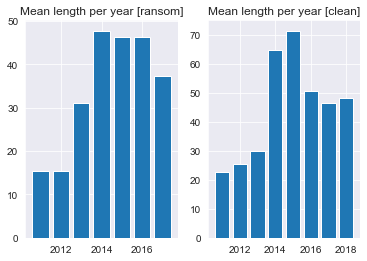

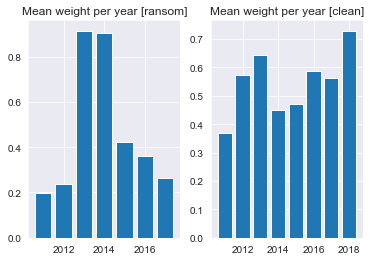

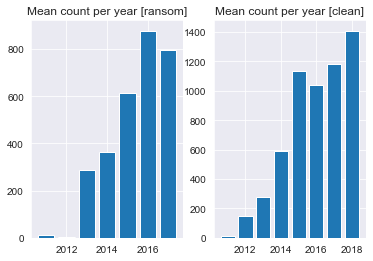

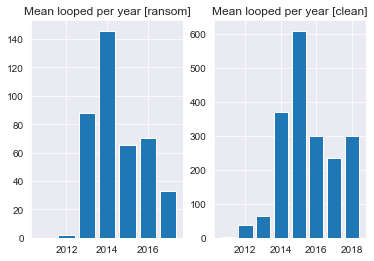

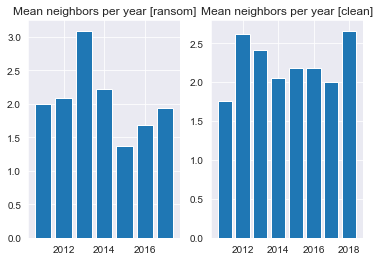

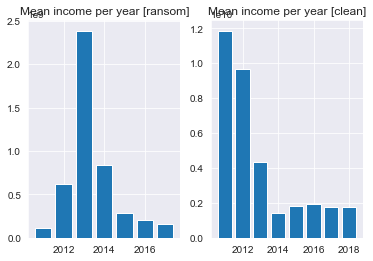

In [30]:
for f in features[3:]:
    yrs = list(mean_red_per_yr[f].index)

    fig, ax = plt.subplots(1,2)
    ax[0].set_title('Mean {} per year [ransom]'.format(f))
    #plt.xlabel('year')
    ax[0].bar(yrs,mean_red_per_yr[f])
    yrs.append(2018)
    ax[1].set_title('Mean {} per year [clean]'.format(f))
    ax[1].bar(yrs,mean_white_per_yr[f])
    del yrs, fig, ax


### test/train

In [31]:
#dft.rename(columns={"label":"labels"}, inplace=True)
label = dft.label.apply(lambda x: 0 if x=='white' else 1)


In [32]:
label.value_counts()

0    345060
1      4944
Name: label, dtype: int64

In [33]:
# labels = labels_to_binary(dft.label) # recast labels into binary

In [34]:
#labels_df = pd.DataFrame(labels,columns=['labels'])

In [35]:
print('Percentage of labels \
belonging to ransomware class: {:.2}'.format( (np.sum(label) / len(label)) * 100) )

Percentage of labels belonging to ransomware class: 1.4


**Defining {X, X_test, x_rain, y_test, y_train}**

In [36]:
X_df = dft.drop(['label'],axis=1) # X=features [original]
X = X_df.to_numpy()

In [37]:
labels_df = label.astype(int)
y_df = labels_df

In [38]:
X_df

,n_day,address,year,day,length,weight,count,looped,neighbors,income
2667698,2637,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,5.772641e+08
2013400,1982,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,1.000000e+08
2704440,2673,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,2.999500e+08
1650833,1620,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,2.990000e+08
1586811,1556,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,4.000000e+07
...,...,...,...,...,...,...,...,...,...,...
2796843,2766,3GATJRb9VFCDRe8wQodrNvUouTWGwjLmhM,2018,211,10,0.125000,1,0,2,2.600785e+10
1036846,1006,18JuSPFSb4f1iWgeMenS6kFeRw2FYDX1kz,2013,276,4,0.166667,1,0,2,3.012661e+08
1932590,1901,1KSjpKdmpFtbLQqbhCoQ8g127AzGq8CjaY,2016,76,144,0.002160,3928,3809,2,1.213316e+08
730452,699,1A3AQAvJLVqne7ud7JT6nb3n1gkhpz7DuT,2012,334,0,1.000000,1,0,1,4.997700e+08


In [39]:
X_df['n_day'].astype(int)

2667698    2637
2013400    1982
2704440    2673
1650833    1620
1586811    1556
           ... 
2796843    2766
1036846    1006
1932590    1901
730452      699
1063408    1032
Name: n_day, Length: 350004, dtype: int64

In [40]:
x_train, x_test, Y_train, Y_test = test_train_time(X_df, labels_df, t0=t0)

In [41]:
[Y_test[i].value_counts() for i in range(len(Y_train))]

[0    2800
 1      31
 Name: label, dtype: int64,
 0    4282
 1      37
 Name: label, dtype: int64,
 0    4904
 1      23
 Name: label, dtype: int64,
 0    5507
 1      13
 Name: label, dtype: int64]

In [42]:
t0 - 1 == x_test[3].n_day.max() # check that the times match up

True

In [43]:
Y_test[3]

2448188    0
2453764    0
2445267    0
2477193    0
2451404    0
          ..
2443770    0
2443215    0
2447587    0
2471414    0
2438886    0
Name: label, Length: 5520, dtype: int64

In [44]:
x_test[2].iloc[2:,5]

2445267    1.000000
2416100    1.250000
2441030    0.125000
2438461    0.197468
2425097    1.000000
             ...   
2443215    0.500000
2447587    0.500000
2423088    0.953125
2438886    1.000000
2412425    0.500000
Name: weight, Length: 4925, dtype: float64

In [45]:
# WORKING test train split. We perform many operations on this data
# We will down sample this data for plotting, testing, and training optimization
#X_train, X_test, y_train, y_test = train_test_split(
#    X_df,                        # design matrix
#    labels_df,                   # y
#    stratify = labels,           #  stratify preserves the large imbalance in the target variable
#    random_state = RAND_STATE,
#    test_size = SPLIT_RATIO
##)

In [46]:
#if SAVE_TEST_TRAIN == True:
#    with open('X_train_y_train_X_test_y_test_label_v3_01.pickle', 'wb') as save_file:
#        pickle.dump([X_train, y_train, X_test, y_test], save_file)

if SAVE_TEST_TRAIN == True:
    fname = 'x_train_Y_train_x_test_Y_test_v2_0'+str(NF)+'.pickle'
    with open(fname, 'wb') as save_file:
        for i in range(len(x_train)):
            pickle.dump([x_train, Y_train, x_test, Y_test], save_file)

# 2.0 Feature Analysis

* Transform features to reduce their skew
* Normalize to unit variance and zero mean for distance classification
* Engineer new features from the old ones

In [47]:
pt = PowerTransformer(method='box-cox') # transformer to reduce skew, not standard

In [48]:
def plot_box(col_var):
        return sns.boxplot(x=col_var)
def plot_pdf(col_var, title=''):
        # plots distributions

        #self.col = s.name
        sns.distplot(col_var, color="c")
        plt.title(title +  ' distribution')
        plt.ylabel('$\pho')
        plt.xlabel(col_var.name)
        plt.plot()

In [49]:
class Feature:
    def __init__(self, df, colname):
        self.df = df
        self.col = colname
        self.vec = np.array(self.df[self.col])
        self.series = self.df[self.col]
        if self.series.dtype == 'O':
            pass
        else:
            self.skew = self.series.skew()
            self.mean = self.series.mean()
            self.var  = self.series.var()
            self.std  = self.series.std()
    def plot_pdf(self):
        # plots distributions
        sns.distplot(self.series, color="c")
        plt.title(str(self.col) +  ' distribution')
        plt.ylabel('density')
        plt.xlabel(self.col)
        plt.plot()
    def plot_box(self):
        return sns.boxplot(x=self.series)
    def apply_pt_for_plots(self):
        return pt.fit_transform(self.vec.reshape(-1,1))
    def bc(self):
        # boxcox on column
        return  boxcox(self.series)[0] 
    def yeo(self):   
        # yeo on column
        return  yeojohnson(self.series)[0] 
    def sigmoid(self):
        # logistic function
        return 1 / (1 + np.exp(-self.vec))

In [50]:
x_test[1]

,n_day,address,year,day,length,weight,count,looped,neighbors,income
2411433,2380,1BSvL68Hgq6QWzqVw61gMpE2MbRFwGtUWa,2017,190,144,0.044365,4510,0,2,4.066859e+08
2416100,2385,1A6RmAWW3vTj9Sph7VbUXqZzZgqLBtXhP9,2017,195,30,1.250000,3,0,1,3.622634e+07
2388478,2357,1HwHAvHARrFg2fwqmPjVdbuPNofjZkzTLw,2017,167,0,1.000000,1,0,1,6.000000e+07
2395969,2365,3QqFuf3MyH28fKEpRWcbrrjFjJHSaTKWe3,2017,175,144,0.456726,5068,0,2,2.420320e+08
2401186,2370,13nperwLp6ysFjzTEJgqriUQcC3w8K8YcS,2017,180,2,0.250000,1,0,2,5.075899e+08
...,...,...,...,...,...,...,...,...,...,...
2413266,2382,1KC29n1FBnWc6YVHD88QjyAnFNsmqhMbYY,2017,192,6,1.000000,1,0,2,1.401348e+09
2393076,2362,12dSf4rVRyvrQR3vVorUrSndmyLGQz1wFT,2017,172,4,1.000000,1,0,2,1.119263e+09
2404299,2373,115crDPinvDeeqFWzrsHJ1zqRN7VvApr6i,2017,183,40,0.500000,1,0,2,6.537267e+07
2412425,2381,1HKDpva2fgdZernDrDv4cAoqYgb68TBTwf,2017,191,86,0.500000,1,0,2,9.237963e+08


In [51]:
X_train = x_train[0]
X_test = x_test[0]
y_train = Y_train[0]
y_test = Y_test[0]

In [52]:
train_features = {
    "address": Feature(X_train,'address'),
    "income": Feature(X_train,'income'),
    "day": Feature(X_train, 'day'),
    "year": Feature(X_train,'year'),
    "length": Feature(X_train, 'length'),
    "weight": Feature(X_train, 'weight'),
    "neighbors": Feature(X_train,'neighbors'),
    "count": Feature(X_train,'count'),
    "looped": Feature(X_train,'looped')}

test_features = {
    "address": Feature(X_test,'address'),
    "income": Feature(X_test,'income'),
    "day": Feature(X_test, 'day'),
    "year": Feature(X_test,'year'),
    "length": Feature(X_test, 'length'),
    "weight": Feature(X_test, 'weight'),
    "neighbors": Feature(X_test,'neighbors'),
    "count": Feature(X_test,'count'),
    "looped": Feature(X_test,'looped')}

In [53]:
train_features_d = {} # derived through transformations to be more normally distributed and on smaller domains
test_features_d = {}

train_features_d['year'] = Feature(X_train,'year')
test_features_d['year']  = Feature(X_test,'year')

In [54]:
# statistics of the graph properties
df[df['label']!='white'].groupby('label')[graph_fs].describe()

length                                               \
                      count        mean         std    min    25%    50%   
label                                                                      
APT                     1.0    2.000000         NaN    2.0    2.0    2.0   
Cerber               1083.0   42.035088   57.243543    0.0    2.0    8.0   
CryptConsole            2.0   72.000000  101.823376    0.0   36.0   72.0   
CryptXXX              293.0   48.648464   58.101493    0.0    2.0   16.0   
CryptoLocker         1144.0   30.968531   50.384965    0.0    0.0    6.0   
CryptoTorLocker2015     5.0   32.400000   62.424354    2.0    4.0    4.0   
CryptoWall           1476.0   48.891599   62.199693    0.0    2.0    8.0   
DMALocker              26.0   19.384615   46.150256    0.0    0.0    2.0   
DMALockerv3            51.0   44.666667   63.618446    0.0    0.0    4.0   
EDA2                    1.0  144.000000         NaN  144.0  144.0  144.0   
Flyper                  1.0   14.000000         NaN   14.0   14.0   14.0   
Globe                   7.0   43.714286   68.599597    0.0    1.0    6.0   
GlobeImposter           5.0   33.600000   62.119240    0.0    2.0    4.0   
JigSaw                  1.0    0.000000         NaN    0.0    0.0    0.0   
Locky                 785.0   47.329936   61.892966    0.0    2.0    8.0   
NoobCrypt              45.0   26.844444   55.193031    0.0    0.0    0.0   
Razy                    1.0   54.000000         NaN   54.0   54.0   54.0   
Sam                     1.0    6.000000         NaN    6.0    6.0    6.0   
SamSam                 11.0   43.454545   64.851158    0.0    0.0    8.0   
VenusLocker             2.0    8.000000    2.828427    6.0    7.0    8.0   
WannaCry                2.0  144.000000    0.000000  144.0  144.0  144.0   
XLocker                 1.0  144.000000         NaN  144.0  144.0  144.0   

                                   weight             ... neighbors        \
                       75%    max   count       mean  ...       75%   max   
label                                                 ...                   
APT                    2.0    2.0     1.0   1.500000  ...       2.0   2.0   
Cerber                72.0  144.0  1083.0   0.296815  ...       2.0  10.0   
CryptConsole         108.0  144.0     2.0   0.708110  ...       2.0   2.0   
CryptXXX             102.0  144.0   293.0   0.352714  ...       2.0   6.0   
CryptoLocker          28.0  144.0  1144.0   0.840725  ...       3.0  63.0   
CryptoTorLocker2015    8.0  144.0     5.0   0.986878  ...      11.0  16.0   
CryptoWall           144.0  144.0  1476.0   0.767319  ...       2.0  37.0   
DMALocker              6.0  144.0    26.0   0.917706  ...       2.0   6.0   
DMALockerv3          144.0  144.0    51.0   0.530395  ...       1.0   4.0   
EDA2                 144.0  144.0     1.0   0.000303  ...       2.0   2.0   
Flyper                14.0   14.0     1.0   0.500000  ...       2.0   2.0   
Globe                 77.0  144.0     7.0   0.338471  ...       2.0   3.0   
GlobeImposter         18.0  144.0     5.0   0.643282  ...       5.0   9.0   
JigSaw                 0.0    0.0     1.0   0.111111  ...       2.0   2.0   
Locky                144.0  144.0   785.0   0.374995  ...       1.0   6.0   
NoobCrypt              8.0  144.0    45.0   0.732404  ...       1.0   2.0   
Razy                  54.0   54.0     1.0  26.411461  ...      27.0  27.0   
Sam                    6.0    6.0     1.0   0.062500  ...       3.0   3.0   
SamSam                81.0  144.0    11.0   0.570040  ...       2.0   4.0   
VenusLocker            9.0   10.0     2.0   0.041667  ...       2.0   2.0   
WannaCry             144.0  144.0     2.0   0.007810  ...       1.0   1.0   
XLocker              144.0  144.0     1.0   0.412207  ...       1.0   1.0   

                     income                                            \
                      count          mean           std           min   
label                                           

In [55]:
# statistics of the graph properties
dft[dft['label']=='white'].groupby('label')[graph_fs].describe()

length                                                       weight  \
          count       mean        std  min  25%  50%    75%    max     count   
label                                                                          
white  345060.0  44.947992  58.935955  0.0  2.0  8.0  106.0  144.0  345060.0   

                 ... neighbors             income                              \
           mean  ...       75%      max     count          mean           std   
label            ...                                                            
white  0.546767  ...       2.0  12920.0  345060.0  4.323266e+09  1.557013e+11   

                                                                        
              min          25%          50%          75%           max  
label                                                                   
white  30000000.0  73504278.25  200000000.0  999950000.0  4.966515e+13  

[1 rows x 40 columns]

#### 2.1.0 income [bc_income]

In [56]:
train_features['income'].series.describe()

count    1.198900e+04
mean     1.130756e+09
std      5.125942e+09
min      3.000000e+07
25%      5.773252e+07
50%      1.335503e+08
75%      4.989000e+08
max      1.862204e+11
Name: income, dtype: float64

In [57]:
train_features['income'].series.value_counts(bins=5)

(-156190439.204, 37268087840.6]     11943
(37268087840.6, 74506175681.2]         35
(74506175681.2, 111744263521.8]         5
(111744263521.8, 148982351362.4]        5
(148982351362.4, 186220439203.0]        1
Name: income, dtype: int64

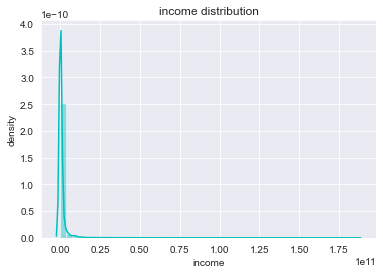

In [58]:
train_features['income'].plot_pdf()

The Shapiro–Wilk test tests the null hypothesis that a sample x1, ..., xn came from a normally distributed population.

In [59]:
#shapiro(train_features['income'].series)
shapiro(X_train['income'])

stats.anderson(X_train.income, dist='norm')

ShapiroResult(statistic=0.18264621496200562, pvalue=0.0)

AndersonResult(statistic=3199.1775991373925, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [60]:
print('Income skew = {}'.format(train_features['income'].skew)) # highly skwewed

Income skew = 15.446287122287593


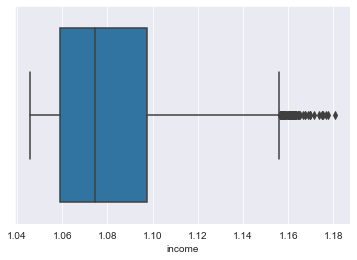

In [61]:
# reducing skew with log
log_inc = np.log(np.log(np.log(X_train['income'])))
ax = plot_box(log_inc)

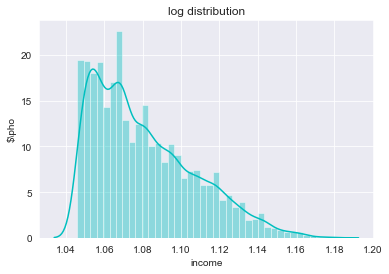

In [62]:
plot_pdf(log_inc, 'log')

Log doesn't quite normalize the distribution. Try with boxcox

In [63]:
# boxcox 
bc_income_train = train_features['income'].bc() # np array
bc_income_test = test_features['income'].bc()   # np array

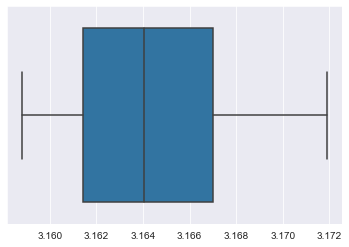

In [64]:
ax = plot_box(bc_income_train) # box plot of boxcox(income)

Applying the box-cox transform has removed the outliers

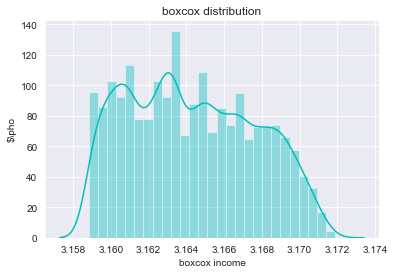

In [65]:
plot_pdf(pd.Series(bc_income_train, name='boxcox income'), 'boxcox')

In [66]:
# Seems good enough to save as a new engineered feature
train_features_d['bc_income'] = Feature(pd.DataFrame(bc_income_train, columns=['bc_income']),'bc_income')
test_features_d['bc_income']  = Feature(pd.DataFrame(bc_income_test, columns=['bc_income']),'bc_income')

In [67]:
train_features_d['bc_income'].skew

0.18723895733221685

In [68]:
shapiro(test_features_d['bc_income'].series)


ShapiroResult(statistic=0.9634581208229065, pvalue=3.5419047294590743e-26)

#### 2.1.1 day [day_of_week]

In [69]:
train_features['day'].series.describe()

count    11989.000000
mean        67.922345
std         27.978093
min         20.000000
25%         44.000000
50%         68.000000
75%         92.000000
max        116.000000
Name: day, dtype: float64

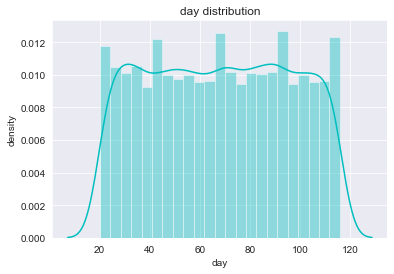

In [70]:
train_features['day'].plot_pdf()

In [71]:
print('The distribution in days is pretty flat. has only minor skew s = {}'.format(train_features['day'].series.skew()))


The distribution in days is pretty flat. has only minor skew s = 0.0002812922921677783


We don't need to transform day


In [72]:
train_features_d['day'] = Feature(X_train,'day')
test_features_d['day'] = Feature(X_test,'day')

###### Engineering day of week feature

In [73]:
def get_day_number(first_day_of_year, day):
    # day number (0 for monday, 6 for sunday) for day
    return (first_day_of_year + day - 1) % 7

In [74]:
day_of_week_train = np.array([])
for index, row in tqdm(X_train.iterrows(),total=X_train.shape[0]):
    # For each data-point, we consider its year and day 
    # and calculate what day of the week (Monday, Tuesday, etc)
    # it was when the transaction happened
    # datetime.datetime(year, 1, 1).weekday() returns the first day of the year
    # using this information, we can calculate the present day

    year_i, day_i = row['year'], row['day']
    day_of_week_train = np.append(day_of_week_train, \
                                  get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

  0%|          | 0/11989 [00:00<?, ?it/s]

In [75]:
day_of_week_test = np.array([])
for index, row in tqdm(X_test.iterrows(),total=X_test.shape[0]):
    #same as above but for test set

    year_i, day_i = row['year'], row['day']
    day_of_week_test = np.append(day_of_week_test, \
                                 get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

  0%|          | 0/2831 [00:00<?, ?it/s]

In [76]:
train_features_d['day_of_week'] = Feature(pd.DataFrame(day_of_week_train.astype(int),columns=['day_of_week']),'day_of_week')
test_features_d['day_of_week'] = Feature(pd.DataFrame(day_of_week_test.astype(int),columns=['day_of_week']),'day_of_week')

####  2.1.2 length [bc_length]

In [77]:
train_features['length'].series.describe()

count    11989.000000
mean        41.394111
std         57.199105
min          0.000000
25%          2.000000
50%          8.000000
75%         70.000000
max        144.000000
Name: length, dtype: float64

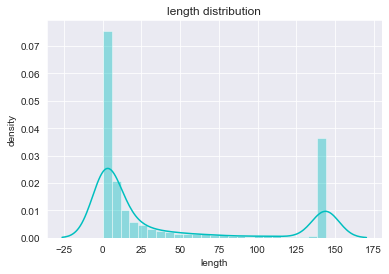

In [78]:
train_features['length'].plot_pdf()

In [79]:
train_features['length'].series.value_counts(bins=2)

(-0.145, 72.0]    9023
(72.0, 144.0]     2966
Name: length, dtype: int64

In [80]:
shapiro(train_features['length'].series)

ShapiroResult(statistic=0.6752521991729736, pvalue=0.0)

This has the form of a bimodal distribution according to the Shapiro test (p<0.05 we )


In [81]:
dft

,n_day,address,year,day,length,weight,count,looped,neighbors,income,label
2667698,2637,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,5.772641e+08,white
2013400,1982,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,1.000000e+08,white
2704440,2673,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,2.999500e+08,white
1650833,1620,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,2.990000e+08,white
1586811,1556,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,4.000000e+07,white
...,...,...,...,...,...,...,...,...,...,...,...
2796843,2766,3GATJRb9VFCDRe8wQodrNvUouTWGwjLmhM,2018,211,10,0.125000,1,0,2,2.600785e+10,white
1036846,1006,18JuSPFSb4f1iWgeMenS6kFeRw2FYDX1kz,2013,276,4,0.166667,1,0,2,3.012661e+08,white
1932590,1901,1KSjpKdmpFtbLQqbhCoQ8g127AzGq8CjaY,2016,76,144,0.002160,3928,3809,2,1.213316e+08,white
730452,699,1A3AQAvJLVqne7ud7JT6nb3n1gkhpz7DuT,2012,334,0,1.000000,1,0,1,4.997700e+08,white


In [82]:
dft[dft['label']!='white'].groupby('label')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
APT,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
Cerber,1083.0,42.035088,57.243543,0.0,2.0,8.0,72.0,144.0
CryptConsole,2.0,72.000000,101.823376,0.0,36.0,72.0,108.0,144.0
CryptXXX,293.0,48.648464,58.101493,0.0,2.0,16.0,102.0,144.0
CryptoLocker,1144.0,30.968531,50.384965,0.0,0.0,6.0,28.0,144.0
CryptoTorLocker2015,5.0,32.400000,62.424354,2.0,4.0,4.0,8.0,144.0
CryptoWall,1476.0,48.891599,62.199693,0.0,2.0,8.0,144.0,144.0
DMALocker,26.0,19.384615,46.150256,0.0,0.0,2.0,6.0,144.0
DMALockerv3,51.0,44.666667,63.618446,0.0,0.0,4.0,144.0,144.0


In [83]:
print("Breakdown of lengths per {}".format(dft[dft['label']!='white'].groupby('label')['length'].mean())), dft[dft['label'] != 'white'].groupby('label')['length'].describe()['mean'].mean()

Breakdown of lengths per label
APT                      2.000000
Cerber                  42.035088
CryptConsole            72.000000
CryptXXX                48.648464
CryptoLocker            30.968531
CryptoTorLocker2015     32.400000
CryptoWall              48.891599
DMALocker               19.384615
DMALockerv3             44.666667
EDA2                   144.000000
Flyper                  14.000000
Globe                   43.714286
GlobeImposter           33.600000
JigSaw                   0.000000
Locky                   47.329936
NoobCrypt               26.844444
Razy                    54.000000
Sam                      6.000000
SamSam                  43.454545
VenusLocker              8.000000
WannaCry               144.000000
XLocker                144.000000
Name: length, dtype: float64


(None, 47.72446255626962)

In [84]:
train_features['length'].skew # check how symmetric the pdf is

1.080415447007993

In [85]:
# check whether log and sqrt help the skew
X_tra_v = train_features['length'].vec
opsXa = np.log(np.sqrt(X_tra_v + 1e-6))
train_features['length'].skew, np.sqrt(X_train['length']).skew(), pd.Series(opsXa).skew()


(1.080415447007993, 0.69370952911094, -1.0505068564185922)

In [86]:
#constructing the feature
bc_length_train = boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-6))))**2)[0]
bc_length_test  = boxcox((np.sin(np.log(np.sqrt(np.array(X_test['length']) + 1e-6))))**2)[0]

In [87]:
# new features
train_features_d['bc_length'] = Feature(pd.DataFrame(bc_length_train, columns=['bc_length']),'bc_length')
test_features_d['bc_length'] = Feature(pd.DataFrame(bc_length_test, columns=['bc_length']),'bc_length')

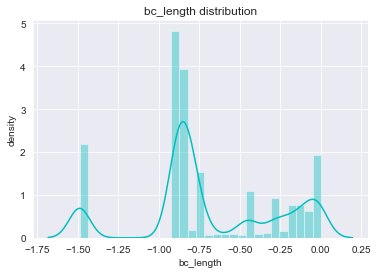

In [88]:
train_features_d['bc_length'].plot_pdf()

In [89]:
train_features_d['bc_length'].skew # the skew has improved but it's now biased

-0.036013946057797744

#### 2.1.3 weight [yeo_weight]

In [90]:
train_features['weight'].series.describe()

count    1.198900e+04
mean     5.609908e-01
std      1.167580e+00
min      1.920956e-37
25%      4.166667e-02
50%      4.085426e-01
75%      1.000000e+00
max      4.290538e+01
Name: weight, dtype: float64

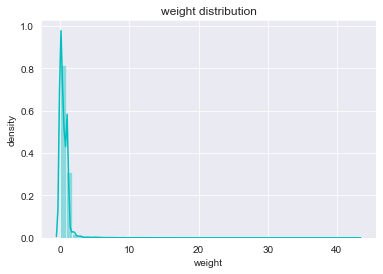

In [91]:
train_features['weight'].plot_pdf()

In [92]:
train_features['weight'].skew # very skewed!

16.20220135081876

In [93]:
train_features_d['yeo_weight'] = Feature( pd.DataFrame(train_features['weight'].yeo(),
                    columns=['yeo_weight']),'yeo_weight' )
test_features_d['yeo_weight'] = Feature( pd.DataFrame(test_features['weight'].yeo(),
                    columns=['yeo_weight']),'yeo_weight' )

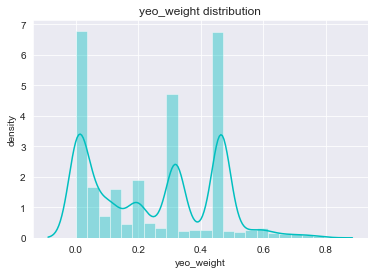

In [94]:
train_features_d['yeo_weight'].plot_pdf()

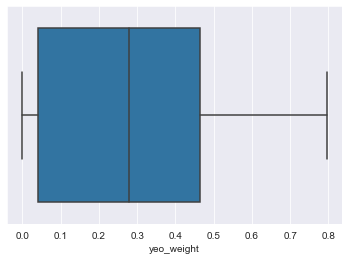

In [95]:
#plotting box plots
ax = plot_box(train_features_d['yeo_weight'].series)

#sns.boxplot(x=yeo_weight_train_ft.series)

In [96]:
train_features_d['yeo_weight'].skew

0.1621168938212961

#### 2.1.4 address [logbc_n_address]

In [97]:
train_features_d['address'] = Feature(X_train,'address')
test_features_d ['address'] = Feature(X_test, 'address')


In [98]:
X_train_address_ft = Feature(X_train,'address')
X_test_address_ft  = Feature(X_test,'address')

In [99]:
X_train['address'].value_counts()

1DtyvLb1pDzXVoaVnJLAFzBJN6b4gcJSdR    5
1BDomT52u3YU3UPHFbH8iZwdjQU5TxxSy6    2
1LvjTxjFnjomvvMK8CGx1qZ1zpLJFUFRmq    2
3PbacVZwS2L5i9C2Cmz9rPu8s4qjyYkufk    2
1GvgRRnLpUP7KsLZLE23ridD45MUxHoAJ4    2
                                     ..
3M7yZsM7438qfD51FDP2TcfDHC4svHqq3g    1
1Mi15qSiUrkSTJhLtPje1KBzRY7RQLjp8G    1
1LNbVGzrnC1Pfs274fUHxxSrJY1KLV3D6     1
1HQPibmJFMoUUjC8KgKA4pff5hBC9zXB5R    1
3Js9vpJQmasCHqwWLoZt6wsW29yFSvd4cw    1
Name: address, Length: 11967, dtype: int64

##### Highest paid ransom address

In [100]:
print('the highest income address is')
dft[dft.label != 'white'][['income','address']].sort_values(by='income',ascending=False).head(1)['address']

the highest income address is


2412    135N2nfAkextd6E25quXpM98qLSi2BccCb
Name: address, dtype: object

In [101]:
df.address.value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    46
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit    32
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza    29
1LEq4WmpCrqBd7V3PywE2nvFUFC3QTe52x    24
1CVWpTNwNYGdKgZRohiiVFrnFNbw8anG9     22
                                      ..
18G6AdoGeupkN1kcTqL6UqXTaXuNhtvBTG     1
1CnkW2hw8zBhGsZ4WYThD1STcEAqerH8wu     1
1DhVxdtuFMeew9o9Cfi8h5CdF7LQkViwtZ     1
16ioXEz3NkjcvhbKiNdma3AJhPGnyBnvkJ     1
1MfphSj17CXv6EkUU2siqMTUzV71DZbi2V     1
Name: address, Length: 336348, dtype: int64

In [102]:
df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU'].label

34381    CryptoLocker
34315    CryptoLocker
34298    CryptoLocker
34239    CryptoLocker
33971    CryptoLocker
34203    CryptoLocker
34361    CryptoLocker
33979    CryptoLocker
33990    CryptoLocker
34181    CryptoLocker
34339    CryptoLocker
34075    CryptoLocker
33967    CryptoLocker
34345    CryptoLocker
34166    CryptoLocker
34279    CryptoLocker
34242    CryptoLocker
34232    CryptoLocker
34276    CryptoLocker
34202    CryptoLocker
34102    CryptoLocker
34170    CryptoLocker
34211    CryptoLocker
34121    CryptoLocker
34186    CryptoLocker
34245    CryptoLocker
34266    CryptoLocker
34086    CryptoLocker
34016    CryptoLocker
34234    CryptoLocker
34284    CryptoLocker
34144    CryptoLocker
34373    CryptoLocker
34250    CryptoLocker
34201    CryptoLocker
34351    CryptoLocker
34026    CryptoLocker
34368    CryptoLocker
34184    CryptoLocker
33976    CryptoLocker
33970    CryptoLocker
34094    CryptoLocker
34129    CryptoLocker
34100    CryptoLocker
34065    CryptoLocker
34070    C

In [103]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address[worst_culprit_address['year']==2013].describe()

,year,day,length,weight,count,looped,neighbors,income
count,27.0,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,2.700000e+01
mean,2013.0,268.444444,12.666667,1.271758,72.777778,0.0,1.407407,3.236863e+09
std,0.0,80.492873,38.072805,0.634253,277.514287,0.0,0.636049,2.781155e+09
min,2013.0,92.000000,0.000000,0.500000,1.000000,0.0,1.000000,1.655000e+08
25%,2013.0,204.500000,0.000000,1.000000,1.000000,0.0,1.000000,1.339505e+09
50%,2013.0,297.000000,0.000000,1.000000,2.000000,0.0,1.000000,2.069190e+09
75%,2013.0,336.500000,4.000000,1.281250,3.000000,0.0,2.000000,4.732336e+09
max,2013.0,364.000000,144.000000,3.250000,1355.000000,0.0,3.000000,1.009315e+10


In [104]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address[worst_culprit_address['year']==2014].describe()

,year,day,length,weight,count,looped,neighbors,income
count,19.0,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,1.900000e+01
mean,2014.0,82.526316,0.736842,1.355263,1.894737,0.0,1.842105,2.347847e+09
std,0.0,51.693937,1.521772,0.548456,0.994135,0.0,0.958190,4.857447e+09
min,2014.0,5.000000,0.000000,0.500000,1.000000,0.0,1.000000,5.495000e+07
25%,2014.0,40.000000,0.000000,1.000000,1.000000,0.0,1.000000,3.446500e+08
50%,2014.0,81.000000,0.000000,1.000000,2.000000,0.0,2.000000,7.036700e+08
75%,2014.0,122.500000,1.000000,1.500000,3.000000,0.0,2.500000,1.572070e+09
max,2014.0,173.000000,6.000000,2.500000,4.000000,0.0,4.000000,2.107868e+10


In [105]:
worst_culprit_address[['length','year','day']].groupby('year')['length'].var()

year
2013    1449.538462
2014       2.315789
Name: length, dtype: float64

##### Feature engineering:  logbc_n_address_train
* the number of times the address appears (log boxcox transformation applied)

In [106]:
address_cnts = train_features_d['address'].series.value_counts()
print('An address is repeated an average of {:.3f} number of times'.format(np.mean(address_cnts)))

An address is repeated an average of 1.002 number of times


In [107]:
address_cnts.skew()

45.22977870535006

In [108]:
dict_address_cnts = dict(X_train['address'].value_counts())
n_address = boxcox(np.array(list(dict_address_cnts.values())))[0]
# 
for index, key in tqdm(enumerate(dict_address_cnts.keys()),total=len(dict_address_cnts)):
    # updating the dictionary with number of times each address appears with the boxcox transformation applied to fix the skewness
    dict_address_cnts.update({key: address_cnts[index]})

  0%|          | 0/11967 [00:00<?, ?it/s]

In [109]:
#Since this is an extremely skewed feature let's only visualize the 1st percentile points
one_percentile = np.percentile(address_cnts, 99)
n_addresses_1perc = np.array([element for element in address_cnts if element <= one_percentile])

Text(0.5, 1.0, 'addresses cnts within 1st percentile')

<AxesSubplot:title={'center':'addresses cnts within 1st percentile'}, ylabel='Density'>

Text(0.5, 0, 'n_addresses')

Text(0, 0.5, 'density')

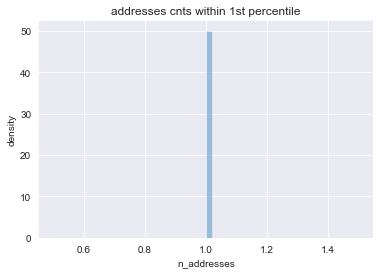

In [110]:
#checking points only within 1st percentile
plt.title('addresses cnts within 1st percentile')
sns.distplot(n_addresses_1perc)
plt.xlabel('n_addresses')
plt.ylabel('density')
plt.show()

In [111]:
dict_address_cnts

{'1DtyvLb1pDzXVoaVnJLAFzBJN6b4gcJSdR': 5,
 '1BDomT52u3YU3UPHFbH8iZwdjQU5TxxSy6': 2,
 '1LvjTxjFnjomvvMK8CGx1qZ1zpLJFUFRmq': 2,
 '3PbacVZwS2L5i9C2Cmz9rPu8s4qjyYkufk': 2,
 '1GvgRRnLpUP7KsLZLE23ridD45MUxHoAJ4': 2,
 '19Cy723nNXMwq6VTPkmb41Fr7Eu5Ra3ccv': 2,
 '1PFTTSSR23n71pYMjzNcEDTUcPGDNmChN': 2,
 '18S5LjDUrgkxZToJL35Q3RhxpLzhG2yUTA': 2,
 '1Gk8S3GsNnJ3njnz3rrudMjvocpSuzrWrd': 2,
 '1DsXznM17CKq8jGoEpuHxKwcntaN67vFes': 2,
 '1N6GyXrAHYqWAoYh4iAXW8AqxdFeqJFQY5': 2,
 '3P4C7jpF1oxHgxqt4VgMRcCBEV3YEpaDUm': 2,
 '17wsG38etiie43v2rApt4CUnRvREKRmmWp': 2,
 '19LaLdu1ZDvcEsB4LWQjbEZBYw44yoKurN': 2,
 '38DsV55ebCeq74myzr1ugAJLFNjPNiojnE': 2,
 '1N3YSdYwHU9dCbzS3sSs3SwVX8N45QYgwj': 2,
 '1J81H33K3ue4CaN1XdSRbBjYCBGGAHce7Y': 2,
 '1QJcp9tX1WxjEVCZ38RGa59tLZwvvEFmaS': 2,
 '1NQZ4kggPJb717yZKzZMyv1iVme7sRcnsZ': 2,
 '1PqUixWdbQPmbRdjbptmMN7WkAK7CgKDg6': 1,
 '1CMZRr1VaRLUvGRpmCgGYNUzLShCFttCsp': 1,
 '3DX4X6tyTwfKpzungvxNRVo4Uh2zkx85Px': 1,
 '12R6WJf27Ej96SuS5ywSQDfC539153E35w': 1,
 '1H7kgmCACyHQHUDt8fBDcAHTPNu76jeQr

In [112]:
len(X_train['address'].value_counts())

11967

In [113]:
n_address.min()

0.0

In [114]:
bc_address_n = boxcox(np.array(list(dict_address_cnts.values())))[0] # 
pd.Series(bc_address_n).skew()

25.039985494785466

Text(0.5, 1.0, 'bc num address distribution')

<AxesSubplot:title={'center':'bc num address distribution'}, ylabel='Density'>

Text(0.5, 0, 'addresses')

Text(0, 0.5, 'density')

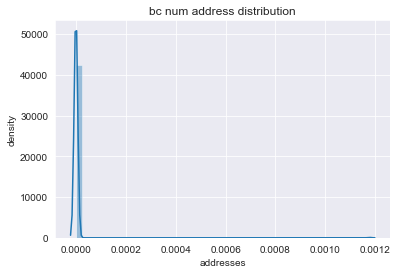

In [115]:
#plot to print distribution of n_addresses
plt.title('bc num address distribution')
sns.distplot(bc_address_n)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [116]:
bc_n_address_train = np.array([])

for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0]):
    # For each address in the training set append the boxcox'd
    # number of times it appears in the training set

    n_address_i = dict_address_cnts.get(X_train.loc[index]['address'])
    
    bc_n_address_train = np.append(bc_n_address_train, n_address_i)

bc_n_address_test = np.array([])
min_dict_n_address = min(list(dict_address_cnts.values()))

for index, row in tqdm(X_test.iterrows(), total=X_test.shape[0]):
    # For each address in the training set append the boxcox'd
    # number of times it appears in the training set
    try:
        #we do the same as above
        n_address_i = dict_address_cnts[X_test.loc[index]['address']]
    except KeyError:
        #KeyError arises when the addreses in training set has not been seen before (i.e cold start)
        #For this, we assign the minimum value to it

        n_address_i = min_dict_n_address #Addressing cold start
    bc_n_address_test = np.append(bc_n_address_test, n_address_i)

  0%|          | 0/11989 [00:00<?, ?it/s]

  0%|          | 0/2831 [00:00<?, ?it/s]

Text(0.5, 1.0, 'boxcox address counts distribution')

<AxesSubplot:title={'center':'boxcox address counts distribution'}, ylabel='Density'>

Text(0.5, 0, 'addresses')

Text(0, 0.5, 'density')

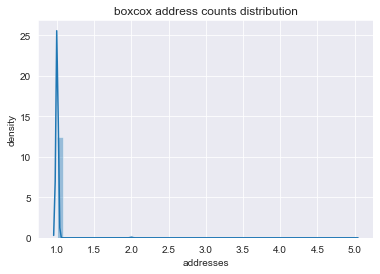

In [117]:
plt.title('boxcox address counts distribution')
sns.distplot(bc_n_address_train)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

Text(0.5, 1.0, 'log boxcox address counts distribution)')

<AxesSubplot:title={'center':'log boxcox address counts distribution)'}, ylabel='Density'>

Text(0.5, 0, 'addresses')

Text(0, 0.5, 'density')

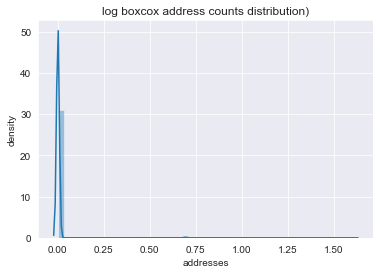

In [118]:
plt.title('log boxcox address counts distribution)')
sns.distplot(np.log(bc_n_address_train)) 
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [119]:
logbc_n_address_train = np.log(bc_n_address_train)
logbc_n_address_test = np.log(bc_n_address_test)

In [120]:
train_features_d['logbc_n_address'] = Feature( pd.DataFrame(logbc_n_address_train,
                    columns=['logbc_n_address']),'logbc_n_address' )
test_features_d['logbc_n_address']  = Feature( pd.DataFrame(logbc_n_address_test,
                    columns=['logbc_n_address']),'logbc_n_address' )

In [121]:
train_features_d['logbc_n_address'].skew

21.54625988189369

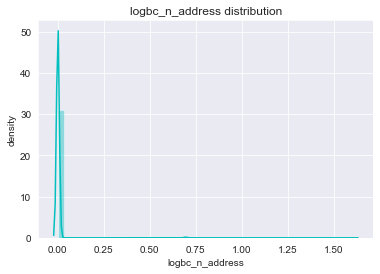

In [122]:
train_features_d['logbc_n_address'].plot_pdf()

#### 2.1.5 neighbors [bc_neighbors]

In [123]:
train_features['neighbors'].series.describe()

count    11989.000000
mean         1.918509
std          3.062187
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max        243.000000
Name: neighbors, dtype: float64

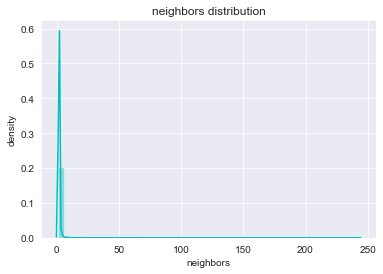

In [124]:
train_features['neighbors'].plot_pdf()

In [125]:
train_features['neighbors'].skew

49.24906810502457

In [126]:
# apply boxcox
bc_neighbors_train = train_features['neighbors'].bc()
bc_neighbors_test = test_features['neighbors'].bc()

In [127]:
# generate new feature
train_features_d['bc_neighbors'] = Feature(pd.DataFrame(bc_neighbors_train,
                    columns=['bc_neighbors']),'bc_neighbors')
test_features_d['bc_neighbors'] = Feature( pd.DataFrame(bc_neighbors_test,
                    columns=['bc_neighbors']),'bc_neighbors')

In [128]:
train_features_d['bc_neighbors'].mean# skew is reduced

0.4609500245589185

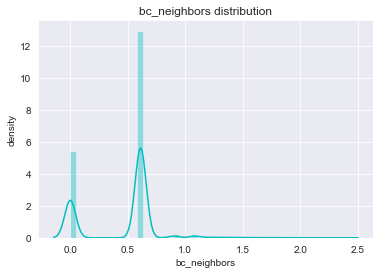

In [129]:
train_features_d['bc_neighbors'].plot_pdf()

In [130]:

dft[dft['label'] != 'white'].groupby('label')['neighbors'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
APT,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
Cerber,1083.0,2.021237,0.445258,1.0,2.0,2.0,2.0,10.0
CryptConsole,2.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
CryptXXX,293.0,1.982935,0.638155,1.0,2.0,2.0,2.0,6.0
CryptoLocker,1144.0,2.868881,3.522746,1.0,1.0,2.0,3.0,63.0
CryptoTorLocker2015,5.0,8.400000,5.594640,2.0,4.0,9.0,11.0,16.0
CryptoWall,1476.0,2.007453,2.405772,1.0,1.0,1.0,2.0,37.0
DMALocker,26.0,1.692308,1.257592,1.0,1.0,1.0,2.0,6.0
DMALockerv3,51.0,1.176471,0.517914,1.0,1.0,1.0,1.0,4.0


In [131]:

dft[dft['label'] == 'white'].groupby('label')['neighbors'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
white,345060.0,2.229673,28.972954,1.0,1.0,2.0,2.0,12920.0


#### 2.1.6 looped  [sig_looped]

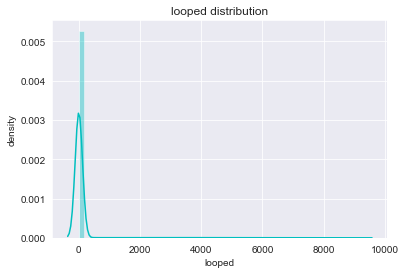

In [132]:
train_features['looped'].plot_pdf()

In [133]:
train_features['looped'].skew

7.503064401150035

In [134]:
# apply sigmoid
sig_looped_train = train_features['looped'].sigmoid()
sig_looped_test  = test_features['looped'].sigmoid()

In [135]:
# generate new feature
train_features_d['sig_looped'] = Feature(pd.DataFrame(sig_looped_train,
                    columns=['sig_looped']),'sig_looped' )
test_features_d['sig_looped'] = Feature(pd.DataFrame(sig_looped_test,
                    columns=['sig_looped']),'sig_looped' )

In [136]:
train_features_d['sig_looped'].skew

3.90849074891445

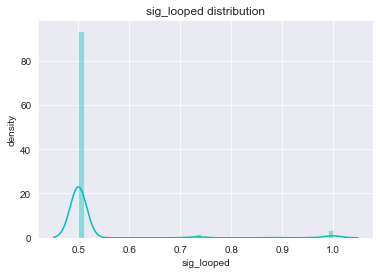

In [137]:
train_features_d['sig_looped'].plot_pdf()

#### 2.1.7 count [log_count]

In [138]:
#X_train_cnt_ft = feature(X_train,'count')
#X_test_cnt_ft  = feature(X_test,'count')

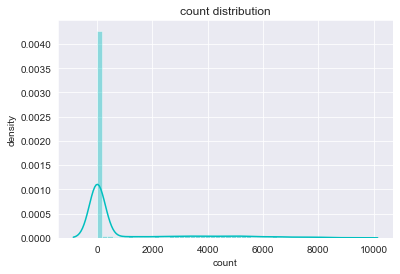

In [139]:
train_features['count'].plot_pdf()

In [140]:
train_features['count'].skew

2.2853056306430606

In [141]:
min(train_features['count'].vec)

1

In [142]:
log_count_train = np.log(train_features['count'].vec)
log_count_test  = np.log(test_features['count'].vec)

In [143]:
# generate new feature
train_features_d['log_count'] = Feature(pd.DataFrame(log_count_train,
                    columns=['log_count']),'log_count')
test_features_d['log_count'] = Feature(pd.DataFrame(log_count_test,
                    columns=['log_count']),'log_count')

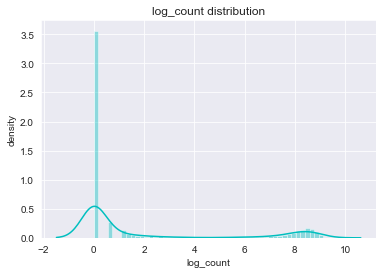

In [144]:
train_features_d['log_count'].plot_pdf()

In [145]:
train_features_d['log_count'].skew

1.3732798587500257

# 3.0 Standardizing and Encoding

In [146]:
list(train_features_d.keys())

['year',
 'bc_income',
 'day',
 'day_of_week',
 'bc_length',
 'yeo_weight',
 'address',
 'logbc_n_address',
 'bc_neighbors',
 'sig_looped',
 'log_count']

In [147]:
# original columns to get scaled for distance based classifiers
cols_orig = [ 
    'year',
    'day',
    'length',
    'weight',
    'count',
    'looped',
    'neighbors',
    'income']
# new columns to get scaled for distance based classifiers
cols_new = [
    'address',
    'bc_income',
    'bc_length',
    'yeo_weight',
    'logbc_n_address',
    'bc_neighbors',
    'sig_looped',
    'log_count',
    'year',
    'day',
    'day_of_week'
]

cols = cols_orig + cols_new
num_to_enc = 1

In [148]:
X_train_d = pd.DataFrame()
X_test_d = pd.DataFrame()

In [149]:
train_features_d

{'year': <__main__.Feature at 0x2a1bfbd60>,
 'bc_income': <__main__.Feature at 0x2a48227f0>,
 'day': <__main__.Feature at 0x2a48bb220>,
 'day_of_week': <__main__.Feature at 0x2a590c040>,
 'bc_length': <__main__.Feature at 0x2a5930be0>,
 'yeo_weight': <__main__.Feature at 0x2a48d08b0>,
 'address': <__main__.Feature at 0x2a59ec550>,
 'logbc_n_address': <__main__.Feature at 0x2a1c02f40>,
 'bc_neighbors': <__main__.Feature at 0x1351745b0>,
 'sig_looped': <__main__.Feature at 0x2a596feb0>,
 'log_count': <__main__.Feature at 0x1379f9130>}

In [150]:
X_train_d['address']=train_features['address'].vec

In [151]:
for col in cols_new:
    X_train_d[col] = train_features_d[col].vec
    X_test_d[col] = test_features_d[col].vec


In [152]:
y_test

2339882    0
2337946    0
2350164    0
2348030    0
2344793    0
          ..
2357211    0
2350497    0
2359204    0
2341957    0
2358834    0
Name: label, Length: 2831, dtype: int64

In [153]:
if SAVE_TEST_TRAIN == True:
    with open('derived'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

#### 3.1.0 Scaling and encoding the data

In [154]:
# cols to standardize (0 mean, unit variance)
col_names_standardize = ['bc_income',
                         'bc_length',
                         'yeo_weight',
                         'logbc_n_address',
                         'bc_neighbors',
                         'sig_looped',
                         'log_count']
# cols to encode
col_names_encode = ['day_of_week']
col_names_pass = ['year','address', 'day']

In [155]:
X_train_d

,address,bc_income,bc_length,yeo_weight,logbc_n_address,bc_neighbors,sig_looped,log_count,year,day,day_of_week
0,1JYbXc8ULh3opSL2NimX2vQEhCFgQFQ8kS,3.162759,-0.762872,0.194822,0.0,0.611863,0.5,0.000000,2017,45,1
1,1HocteMqu15255SDXsdT6HfBqNaKgjbih6,3.160932,-0.005318,0.022836,0.0,0.000000,0.5,0.693147,2017,32,2
2,1FSSVqbDPwBrE4qrwqhJq3wucoiXwj7e2X,3.163071,-0.886227,0.318354,0.0,0.000000,0.5,0.000000,2017,68,3
3,3JDir1ZMB176HTNQAvnHMp71cUHq5DhQTj,3.161949,-0.280765,0.003295,0.0,0.611863,0.5,1.386294,2017,51,0
4,1JtNYNnGedWenXsH2aa8hF34TY5DGwsTce,3.167333,-0.061437,0.001949,0.0,0.000000,0.5,0.000000,2017,55,4
...,...,...,...,...,...,...,...,...,...,...,...
11984,157ahbqyJ8k1UYDNat8ZS3Hq2hAvp3KfvY,3.167569,-0.886227,0.464282,0.0,0.000000,0.5,0.000000,2017,82,3
11985,14zgQi8ymTDUVfFnQMnd63Bi3iQRRLcnWq,3.163264,-0.886227,0.318354,0.0,0.611863,0.5,0.000000,2017,36,6
11986,1FoTK5rxEP3ehYAKU1p8XSBB8XL9qzzuRz,3.163231,-0.827285,0.045207,0.0,0.611863,0.5,7.949091,2017,96,3
11987,3PZWQepCrZkQU4TrMNHC7BwzqapSQK5Yv8,3.160927,-0.762872,0.318354,0.0,0.611863,0.5,0.693147,2017,70,5


In [156]:
X_train

,n_day,address,year,day,length,weight,count,looped,neighbors,income
2265864,2235,1JYbXc8ULh3opSL2NimX2vQEhCFgQFQ8kS,2017,45,4,0.250000,1,0,2,85812500.0
2253207,2222,1HocteMqu15255SDXsdT6HfBqNaKgjbih6,2017,32,20,0.023438,2,0,1,50437060.0
2289573,2258,1FSSVqbDPwBrE4qrwqhJq3wucoiXwj7e2X,2017,68,0,0.500000,1,0,1,94860000.0
2272067,2241,3JDir1ZMB176HTNQAvnHMp71cUHq5DhQTj,2017,51,8,0.003307,4,0,2,67061348.0
2276668,2245,1JtNYNnGedWenXsH2aa8hF34TY5DGwsTce,2017,55,38,0.001953,1,0,1,593384858.0
...,...,...,...,...,...,...,...,...,...,...
2303207,2272,157ahbqyJ8k1UYDNat8ZS3Hq2hAvp3KfvY,2017,82,0,1.000000,1,0,1,683224789.0
2257268,2226,14zgQi8ymTDUVfFnQMnd63Bi3iQRRLcnWq,2017,36,0,0.500000,1,0,2,101095310.0
2316823,2286,1FoTK5rxEP3ehYAKU1p8XSBB8XL9qzzuRz,2017,96,144,0.047629,2833,0,2,100000000.0
2291070,2260,3PZWQepCrZkQU4TrMNHC7BwzqapSQK5Yv8,2017,70,4,0.500000,2,0,2,50374865.0


In [157]:
# transform the data for use in distance based modeling algorithms [logistic regression]
transformer = ColumnTransformer(
    [('standardize', StandardScaler(), col_names_standardize),
    ('encode', OneHotEncoder(dtype=int), col_names_encode)],
    remainder = 'passthrough',
     verbose_feature_names_out=False)

transformer.fit(X_train_d)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardize', StandardScaler(),
                                 ['bc_income', 'bc_length', 'yeo_weight',
                                  'logbc_n_address', 'bc_neighbors',
                                  'sig_looped', 'log_count']),
                                ('encode', OneHotEncoder(dtype=<class 'int'>),
                                 ['day_of_week'])],
                  verbose_feature_names_out=False)

In [158]:
# std. transformed and encoded variables (np arrays)
X_train_e = transformer.transform(X_train_d)
X_test_e  = transformer.transform(X_test_d)
# std. transformed and encoded variables (df with verbose headers)

X_train_e_df = pd.DataFrame(X_train_e,columns=transformer.get_feature_names_out())
X_test_e_df = pd.DataFrame(X_test_e,columns=transformer.get_feature_names_out())

In [159]:
if SAVE_TEST_TRAIN == True:
    with open('encoded'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)


# 4.0 Resampling

In [160]:
type(y_train)

pandas.core.series.Series

In [161]:
y_test

2339882    0
2337946    0
2350164    0
2348030    0
2344793    0
          ..
2357211    0
2350497    0
2359204    0
2341957    0
2358834    0
Name: label, Length: 2831, dtype: int64

In [162]:
print('Training set has {} rows and {} columns.'.format(X_train.shape[0], X_train.shape[1]))
print('Testing set has {} rows and {} columns.'.format(X_test.shape[0], X_test.shape[1]))
print('Training set has {} points that belong to postitive class (ransomware) and {} points that belong to negative class (white).'.format(
    sum(y_train),
    len(y_train) - sum(y_train)
))
print('Percentage of positive class data-points: {:.2f}%'.format((sum(y_train)/(len(y_train)) * 100)))

Training set has 11989 rows and 10 columns.
Testing set has 2831 rows and 10 columns.
Training set has 234 points that belong to postitive class (ransomware) and 11755 points that belong to negative class (white).
Percentage of positive class data-points: 1.95%


## 4.1 Sampling

In [163]:
from imblearn.over_sampling import SMOTE


### 4.1.0 Downsampling

In [164]:
class Sampler:

    def __init__(self,X):
        self.X_df = pd.DataFrame(X)
        self.positive_df = pd.DataFrame([], columns = self.X_df.columns)
        self.negative_df = pd.DataFrame([], columns = self.X_df.columns)
        self.combined_df = pd.DataFrame([], columns = self.X_df.columns)
        self.X_train_sm =  pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_sm =  pd.DataFrame([], columns = ['lable'])
        self.X_train_rus = pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_rus =  pd.DataFrame([], columns = ['lable'])



    def up_samp_smote(self, X_train, y_train, ratio):
        """Upsamples minority class using SMOTE.
        Ratio argument is the percentage of the upsampled minority class in relation
        to the majority class.
        """
        sm = SMOTE(random_state=RAND_STATE, sampling_strategy=ratio)
        X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
        #print(len(X_train_sm), len(y_train_sm))
        self.X_train_sm, self.y_train_sm = X_train_sm, y_train_sm


    def down_samp_rand(self, X_train, y_train, ratio):
        """Downsamples majority class using random sampling.
        Ratio argument is the ratio of minority class to the downsampled majority
        """
        rus = RandomUnderSampler(sampling_strategy=ratio,random_state=RAND_STATE)
        X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
        self.X_train_rus, self.y_train_rus = X_train_rus, y_train_rus


    def down_samp(self, y_train, prob=0.015):
        index = 0

        for index_df, row in tqdm(self.X_df.iterrows(), total=self.X_df.shape[0]):
            if y_train[index] == 0:
                if np.random.uniform(0, 1) < prob:
                    #picking negative class with a probability=prob
                    self.negative_df = self.negative_df.append(row, ignore_index=True)
                    index += 1
                else:
                    index += 1
            elif y_train[index] == 1:
            #picking all positive data-points
                self.positive_df = self.positive_df.append(row, ignore_index=True)
                index += 1
        self.combined_df = self.positive_df.append(self.negative_df, ignore_index = True)

**e_ds** <n>
- Encoded, standard scaled, and normalized data.
- Split of X_train_e [standardized, encoded] without column headers.

In [165]:
X_train_e_df.drop(columns=['address'],axis=1,inplace=True)

In [166]:
# Create a sample object
e_ds = Sampler(X_train_e_df)

In [167]:
e_ds.down_samp_rand(X_train_e_df, y_train, 0.05) # downsample using random resampling

In [168]:
e_ds.up_samp_smote(e_ds.X_train_rus, e_ds.y_train_rus, 0.25) # upsampling using SMOTE

In [169]:
READ_STATE = False

# 5.0 Modeling

In [170]:
def plot_roc(model, X, y, plot_title):
    plot_roc_curve(model, X, y)
    plt.title(plot_title)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
    plt.legend()
    plt.show()


def confusion_mat(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    label = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    label = np.asarray(label).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=label, fmt='', cmap='Reds')


def tabulate_scores_df(model_name, y_test, y_pred):
    df2 = pd.DataFrame([[
        model_name,
        accuracy_score(y_true=y_test, y_pred=y_pred),
        precision_score(y_true=y_test, y_pred=y_pred),
        recall_score(y_true=y_test, y_pred=y_pred),
        f1_score(y_true=y_test, y_pred=y_pred)]],
        columns=['Type', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

    return df2


In [171]:
class Model:
    def __init__(self, x_tr, y_tr, X_tr, X_tst, routine, params, classifier, crss_vldtr=None):
        '''Model'''
        self.classifier = classifier
        self.X_tst = X_tst


        #  randomized search on hyper parameters
        search = RandomizedSearchCV(
            estimator = routine,
            param_distributions = params,
            scoring = 'accuracy',
            cv = crss_vldtr,
            n_jobs = -1,
            verbose = 1,
            random_state = RAND_STATE,
            return_train_score = True,
            n_iter = 5
        )
        if READ_STATE == True:
            tag = input('Enter head of parameter file to read')
            rf_hps_fname = tag + '_bestparams_sm_e_05.csv'
            print('reading file ', rf_hps_fname)
            bps = pd.read_csv(rf_hps_fname, index_col=False).to_dict('list')
            bps.pop('Unnamed: 0')
            ks = [k for k in bps.keys()]
            vs = [v[0] for v in bps.values()]
            self.best_params = dict( zip(ks,vs) )
        else:
            search.fit(x_tr, y_tr)
            self.best_params = search.best_params_

        print(self.best_params)
        tuned = classifier(**self.best_params,# n_jobs = -1,
                            random_state = RAND_STATE)
        self.tuned = tuned
        # fit
        tuned.fit(x_tr, y_tr)
        # predict
        self.preds_train = tuned.predict(X_tr)
        self.preds_test  = tuned.predict(X_tst)
        self.params      = tuned.get_params()

    def score(self,y_tr,y_tst):
        trn_score_df = tabulate_scores_df('trn', y_tr, self.preds_train)
        tst_score_df = tabulate_scores_df('tst', y_tst, self.preds_test)
        score_df = trn_score_df.append(tst_score_df)
        return score_df

    def roc(self, y_tst, title):
        plot_roc(self.tuned, self.X_tst,y_tst, title)

    def conf_mat(self, y_tr, y_tst):
        plt.figure(figsize=(15,7))

        plt.subplot(1,2,1) # first heatmap
        confusion_mat(y_tr, self.preds_train)

        plt.subplot(1,2,2) # first heatmap
        confusion_mat(y_test, self.preds_test)

        plt.show()

    def feature_imps(self,colnames):
        feat_ranks_df = pd.DataFrame(np.ravel(self.tuned.feature_importances_), index=colnames)
        feat_ranks_df.columns = ['feature importance']
        feat_ranks_df.sort_values(by='feature importance', ascending=False)
        return feat_ranks_df

In [172]:
from collections import Counter
counter = Counter(y_train)
estimate = np.sqrt(counter[0] / counter[1])

In [173]:
from sklearn.svm import LinearSVC

In [174]:
models = {
    "sgd": { "estimator": SGDClassifier(),
             "params": {
                 "loss" : [ "log_loss", "perceptron"],
                 "alpha" : [0.0001, 0.001, 0.01, 0.1],
                 "penalty" : ["l2", "l1", "elasticnet"],
                 "class_weight" : ['balanced', None],}
             },
    "rf": { "estimator": RandomForestClassifier(),
            "params": {
                'max_depth' : [2,5,10,15],
                'n_estimators' : [100, 500, 1000],
                "class_weight" : ['balanced', None],}
            },
    "xgb": {"estimator": XGBClassifier(),
            "params": {
                'n_estimators': stats.randint(150, 1000),
                'learning_rate': stats.uniform(0.01, 0.59),
                'subsample': stats.uniform(0.3, 0.6),
                'max_depth': [3, 4, 5, 6, 7],
                'colsample_bytree': stats.uniform(0.5, 0.4),
               # 'scale_pos_weight' : stats.uniform(estimate,estimate**2),
                'min_child_weight': [1, 2, 3, 4],}
            },
    "lsvc": { "estimator": LinearSVC(),
              "params": { }
              },
    "svc": { "estimator": SVC(),
             "params": {
                 'C': [0.1,1, 10, 100, 1000],
                 'gamma': [1,0.1,0.01,0.001,0.0001],
                 'kernel': ['rbf'],}
             }
}

In [175]:
X_test_e_df.drop(columns=['address'],axis=1,inplace=True)

In [176]:
# Create model
sgd_cl = SGDClassifier(random_state=RAND_STATE, max_iter=3000, learning_rate='optimal')
sgd_params_in = {
    "loss": ["log_loss", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"],
    "class_weight": ['balanced', None]
}
sgd = Model(
    e_ds.X_train_sm, e_ds.y_train_sm,
    X_train_e_df, X_test_e_df,
    sgd_cl, sgd_params_in, SGDClassifier)
sgd.params

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'penalty': 'l1', 'loss': 'log_loss', 'class_weight': None, 'alpha': 0.1}


{'alpha': 0.1,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l1',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [177]:
sgd.score(y_train,y_test)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.187505,0.020285,0.858974,0.039633
0,tst,0.989050,0.000000,0.000000,0.000000


Compare result to original features

In [178]:
# Create model
sgd_cl0 = SGDClassifier(random_state=RAND_STATE, max_iter=4000, learning_rate='optimal',n_jobs=-1)
sgd_params_in = {
    "loss": [ "perceptron"],
    "alpha": [ 0.1],
    "penalty": ["l2", "l1", "elasticnet"],
    "class_weight": ['balanced', None]
}
sgd0 = Model(
    X_train.drop(labels=['address'],axis=1), y_train,
    X_train.drop(labels=['address'],axis=1), X_test.drop(labels=['address'],axis=1),
    sgd_cl0, sgd_params_in, SGDClassifier)
sgd0.params

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'penalty': 'l2', 'loss': 'perceptron', 'class_weight': 'balanced', 'alpha': 0.1}


{'alpha': 0.1,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'perceptron',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [179]:
sgd0.score(y_train,y_test)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.980482,0.0,0.0,0.0
0,tst,0.989050,0.0,0.0,0.0


In [180]:
y_test.value_counts()

0    2800
1      31
Name: label, dtype: int64

In [181]:
pd.Series(sgd0.preds_train).value_counts()

0    11989
dtype: int64

In [182]:
y_test

2339882    0
2337946    0
2350164    0
2348030    0
2344793    0
          ..
2357211    0
2350497    0
2359204    0
2341957    0
2358834    0
Name: label, Length: 2831, dtype: int64

In [183]:
pd.Series(sgd0.preds_test).value_counts()

0    2831
dtype: int64